### Misc Figures and Experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


from typing import Optional
import time

# directly import from latticevision library in directory
from latticevision.device import set_device
from latticevision.img2img.dataset import (
	make_dataset,
	DataConfig,
	no_transform,
	polar_transform,
)
from latticevision.plotting import plot_img2img_samples
from latticevision.img2img import TransUNet, UNet, ViT
from latticevision.img2img.base import (
	ModelConfig,
	NullPosEmbed,
	LearnedPosEmbed,
	SinusoidalPosEmbed,
	RotaryPosEmbed,
)
from latticevision.seed import set_all_random_seeds

from latticevision.cnn.model import ModelConfig as CNNModelConfig
from latticevision.cnn.model import CNN
from latticevision.cnn.eval import fast_cnn_field_tiler

# set random seed for reproducibility
set_all_random_seeds(777)

# for remote use
device = set_device(machine="remote", gpu=True, gpu_id="cuda:0", verbose=True)

# for local use
# device = set_device(machine="local", gpu=True, verbose=True)

Using device: cuda:0 
Hardware:  NVIDIA RTX A6000


In [2]:
# for testing
# dataset_path = "../sample_data/STUN_test_data.h5"
# val_size = 0.4
# test_size = 0.5

dataset_path = "../data/STUN_data.h5"
val_size = 0.1
test_size = 0.2

transform_funcs = [no_transform, polar_transform]

data_config = DataConfig(
	file_path=dataset_path,
	n_rows=192,
	n_cols=288,
	n_replicates=30,
	n_params=3,
	transform_function=transform_funcs[0],
	log_kappa2=True,
	shift_theta=True,
	val_size=val_size,
	test_size=test_size,
	random_state=777,
	verbose=True,
)

data_dict = make_dataset(
	config=data_config,
)

train_df = data_dict["train_df"]
val_df = data_dict["val_df"]
test_df = data_dict["test_df"]

Components in the file: ['fields']
Dataset size (MB):  111375.0001373291
Dataset size (GB):  108.76464857161045
Fields shape:  (8000, 30, 192, 288)
Params shape:  (8000, 3, 192, 288)
Train fields shape:  (7200, 30, 192, 288)
Train params shape:  (7200, 3, 192, 288)
Validation fields shape:  (640, 30, 192, 288)
Validation params shape:  (640, 3, 192, 288)
Test fields shape:  (160, 30, 192, 288)
Test params shape:  (160, 3, 192, 288)


In [ ]:
def plot_example_field_paper(
	dataset,
	config,
	idx: int,
	model_type: str = "STUN",
	field_color: str = "turbo",
	param1_color: str = "viridis",
	param2_color: str = "viridis",
	param3_color: str = "viridis",
	show: bool = True,
) -> None:
	if model_type == "CNN":
		# extract field and params
		field, params = dataset[idx]
		# separate params for plotting
		kappa2 = params[0]
		theta = params[1]
		rho = params[2]

		fig, ax = plt.subplots(figsize=(6, 5))
		im = ax.imshow(field[0], cmap=field_color)
		fig.colorbar(im, ax=ax, orientation="vertical")

		ax.set_title(f"Field #{idx + 1}, Replicate #1")
		ax.set_xlabel(
			rf"$\kappa^2$ = {kappa2:.4f}, $\theta$ = {theta:.2f}, $\rho$ = {rho:.2f}"
		)
		ax.invert_yaxis()

	elif model_type == "STUN":
		# extract field and params
		field = dataset[idx][0][0]
		params = dataset[idx][1]
		# kappa2 transformed back to original scale
		kappa2 = torch.exp(params[0])
		theta = params[1]
		rho = params[2]

		fig, axs = plt.subplots(2, 2, figsize=(10, 7))
		axis_shrink = 0.6
		# spatial field plot
		im1 = axs[0, 0].imshow(field, cmap=field_color)
		axs[0, 0].set_title(r"Spatial Field")
		fig.colorbar(im1, ax=axs[0, 0], orientation="vertical", shrink=axis_shrink)
		axs[0, 0].invert_yaxis()

		# kappa2 plot
		im2 = axs[0, 1].imshow(kappa2, cmap=param1_color)
		axs[0, 1].set_title(r"$\kappa^2(\mathbf{s})$")
		fig.colorbar(im2, ax=axs[0, 1], orientation="vertical", shrink=axis_shrink)
		axs[0, 1].invert_yaxis()

		# theta plot
		im3 = axs[1, 0].imshow(theta, cmap=param2_color)
		if config.transform_function == no_transform:
			axs[1, 0].set_title(r"$\theta(\mathbf{s})$")
		elif config.transform_function == polar_transform:
			axs[1, 0].set_title(r"$f_1$ (Polar) Field")
		fig.colorbar(im3, ax=axs[1, 0], orientation="vertical", shrink=axis_shrink)
		axs[1, 0].invert_yaxis()

		# rho_x plot
		im4 = axs[1, 1].imshow(rho, cmap=param3_color)
		if config.transform_function == no_transform:
			axs[1, 1].set_title(r"$\rho(\mathbf{s})$")
		elif config.transform_function == polar_transform:
			axs[1, 1].set_title(r"$f_2$ (Polar) Field")
		fig.colorbar(im4, ax=axs[1, 1], orientation="vertical", shrink=axis_shrink)
		axs[1, 1].invert_yaxis()

	else:
		print(
			"Invalid model type. Unable to plot field. Please use either STUN or CNN."
		)
		return

	# option set for testing
	if show:
		plt.tight_layout()
		plt.show()
	else:
		plt.close(fig)

### Appendix Training Data Figure

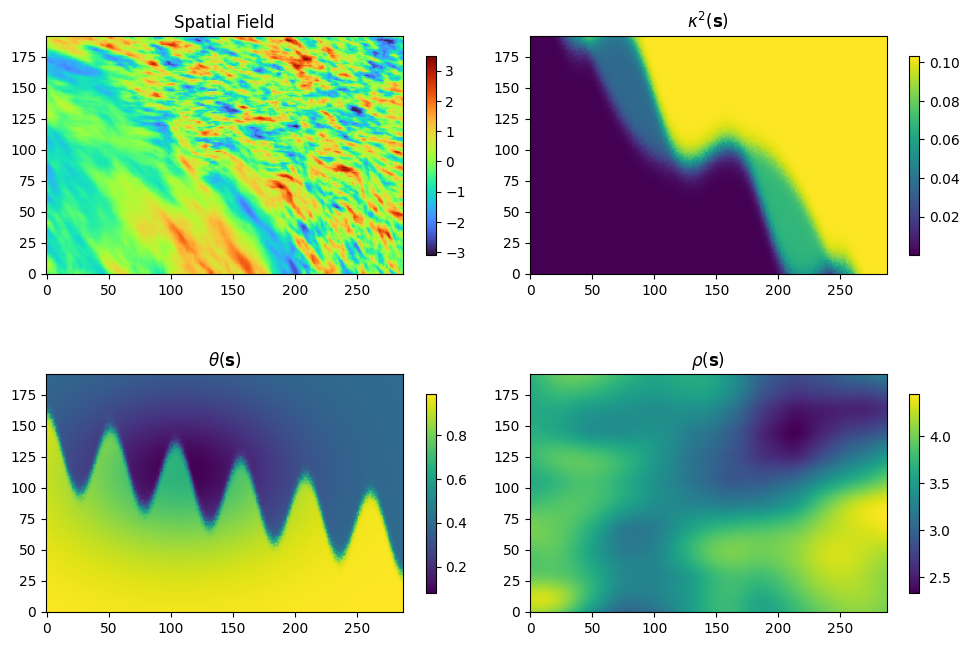

In [ ]:
plot_example_field_paper(
	dataset=train_df,
	config=data_config,
	idx=66,
	model_type="STUN",
	field_color="turbo",
	param1_color="viridis",
	param2_color="viridis",
	param3_color="viridis",
)

In [5]:
cnn_config = CNNModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

cnn_model = CNN(cnn_config).to(device)

state_dict = torch.load(
	"../results/model_wghts/modelCNN_size25_reps30.pth",
	map_location=torch.device(device),
)
cnn_model.load_state_dict(state_dict)
cnn_model.to(device)

total_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")
cnn_model.eval()

Total number of trainable parameters: 2597815


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(30, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): GELU(approximate='none')
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=2304, out_features=500, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=500, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [6]:
test_fields = test_df[:][0]
test_params = test_df[:][1]

print("Test fields shape: ", test_fields.shape)
print("Test params shape: ", test_params.shape)

cnn_outputs = torch.zeros(test_params.size())

Test fields shape:  torch.Size([160, 30, 192, 288])
Test params shape:  torch.Size([160, 3, 192, 288])


In [7]:
for i in range(len(cnn_outputs)):
	cnn_output = fast_cnn_field_tiler(
		model=cnn_model,
		fields=test_fields[i].unsqueeze(0),
		device=device,
		patch_batch_size=10000,
		verbose=False,
		padding_mode="reflect",
		patch_size=25,
	)
	cnn_outputs[i] = cnn_output

cnn_outputs.shape

torch.Size([160, 3, 192, 288])

In [8]:
pos_embeds = [NullPosEmbed, LearnedPosEmbed, SinusoidalPosEmbed, RotaryPosEmbed]

stun_config = ModelConfig(
	patch_size_h=2,
	patch_size_w=2,
	pos_embed_cls=pos_embeds[3],
)
stun_model = TransUNet(stun_config)

modelpath = "../results/model_wghts/modelTransUNet_reps30_posRotaryPosEmbed.pth"
stun_model.load_state_dict(torch.load(modelpath))

# send model to device and count params
stun_model = stun_model.to(device)
total_params = sum(p.numel() for p in stun_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")
stun_model.eval()

Total number of trainable parameters: 105325827


TransUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 128, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(16, 128, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2

#### Timing the I2I model outputs

In [ ]:
# clear cuda cache
test_loader = DataLoader(test_df, batch_size=64, shuffle=False)
stun_outputs = torch.zeros(test_params.size())

starttime = time.time()
with torch.no_grad():
	for batch in test_loader:
		break

	batch = [b.to(device) for b in batch]
	fields, params = batch
	stun_output = stun_model(fields)
	stun_output = stun_output.cpu()
	stun_outputs[: len(stun_output)] = stun_output
	print("STUN output shape: ", stun_output.shape)

print("Time taken: ", time.time() - starttime)
stun_outputs.shape

STUN output shape:  torch.Size([64, 3, 192, 288])
Time taken:  2.777170181274414


torch.Size([160, 3, 192, 288])

In [10]:
unet_config = ModelConfig()
unet_model = UNet(unet_config)
unet_model.to(device)
total_params = sum(p.numel() for p in unet_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")
unet_model.eval()

unet_outputs = torch.zeros(test_params.size())

Total number of trainable parameters: 25224963


In [ ]:
starttime = time.time()
with torch.no_grad():
	# get the first batch of data
	for batch in test_loader:
		break
	batch = [b.to(device) for b in batch]
	fields, params = batch
	unet_output = unet_model(fields)
	unet_output = unet_output.cpu()
	unet_outputs[: len(unet_output)] = unet_output
	print("unet output shape: ", unet_output.shape)

print("Time taken: ", time.time() - starttime)

unet output shape:  torch.Size([64, 3, 192, 288])
Time taken:  0.42723989486694336


In [12]:
vit_config = ModelConfig(
	patch_size_h=16,
	patch_size_w=16,
	pos_embed_cls=pos_embeds[3],
)
vit_model = ViT(vit_config)
vit_model.to(device)
total_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")
vit_model.eval()

vit_outputs = torch.zeros(test_params.size())

Total number of trainable parameters: 91506432


In [ ]:
starttime = time.time()
with torch.no_grad():
	for batch in test_loader:
		break
	batch = [b.to(device) for b in batch]
	fields, params = batch
	vit_output = vit_model(fields)
	vit_output = vit_output.cpu()
	vit_outputs[: len(vit_output)] = vit_output
	print("vit output shape: ", vit_output.shape)

print("Time taken: ", time.time() - starttime)

vit output shape:  torch.Size([64, 3, 192, 288])
Time taken:  0.46910595893859863


### Simulated Data Example Figures

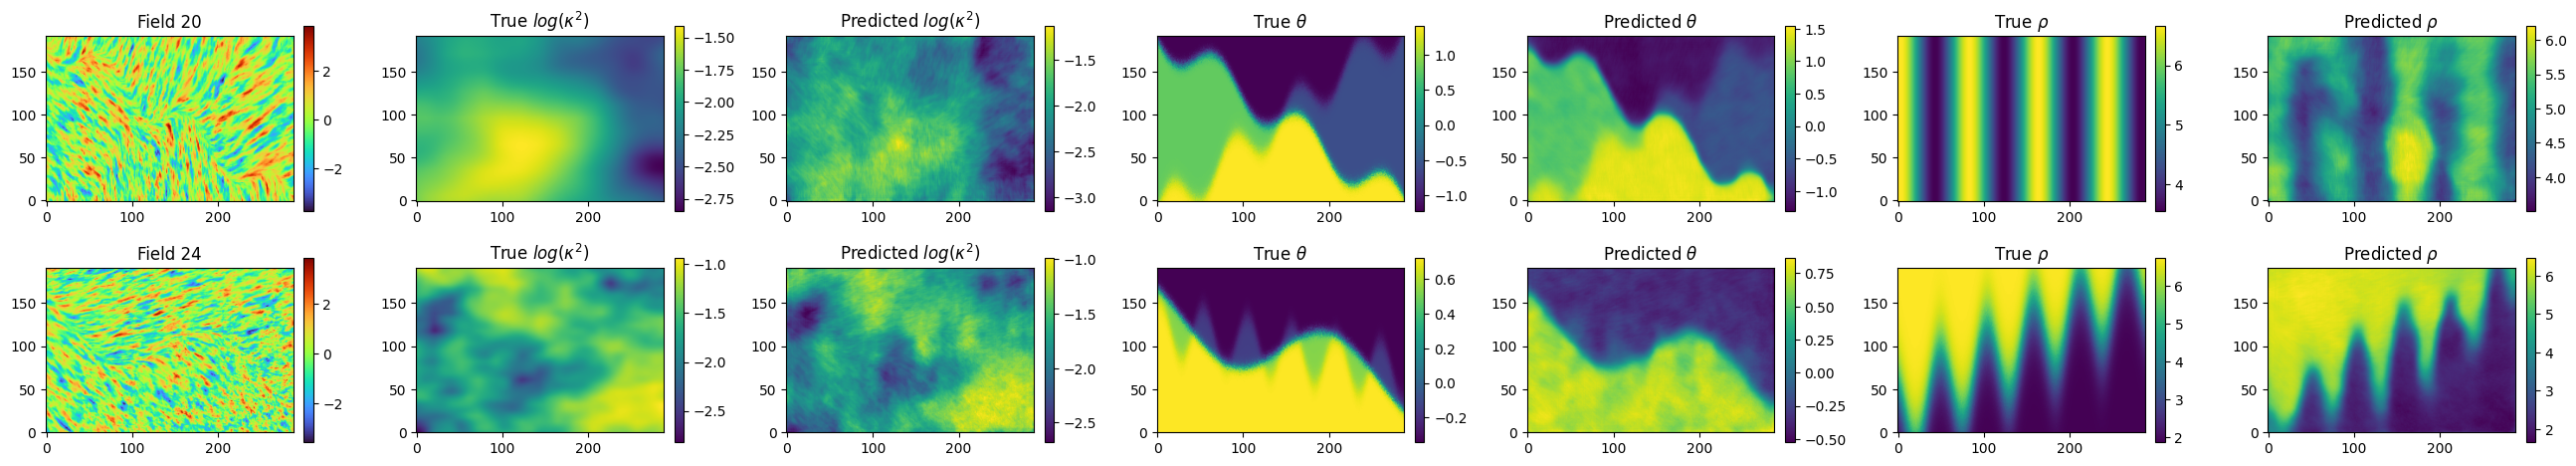

In [15]:
# make inds into a list from 10 to 20
# inds = list(range(40, 50))
inds = [19, 23]

plot_img2img_samples(
	model=stun_model,
	config=data_config,
	device=device,
	test_df=test_df,
	indices=inds,
	random_selection=False,
	num_rand_samples=5,
	awght_not_kappa2=False,
	show=True,
)

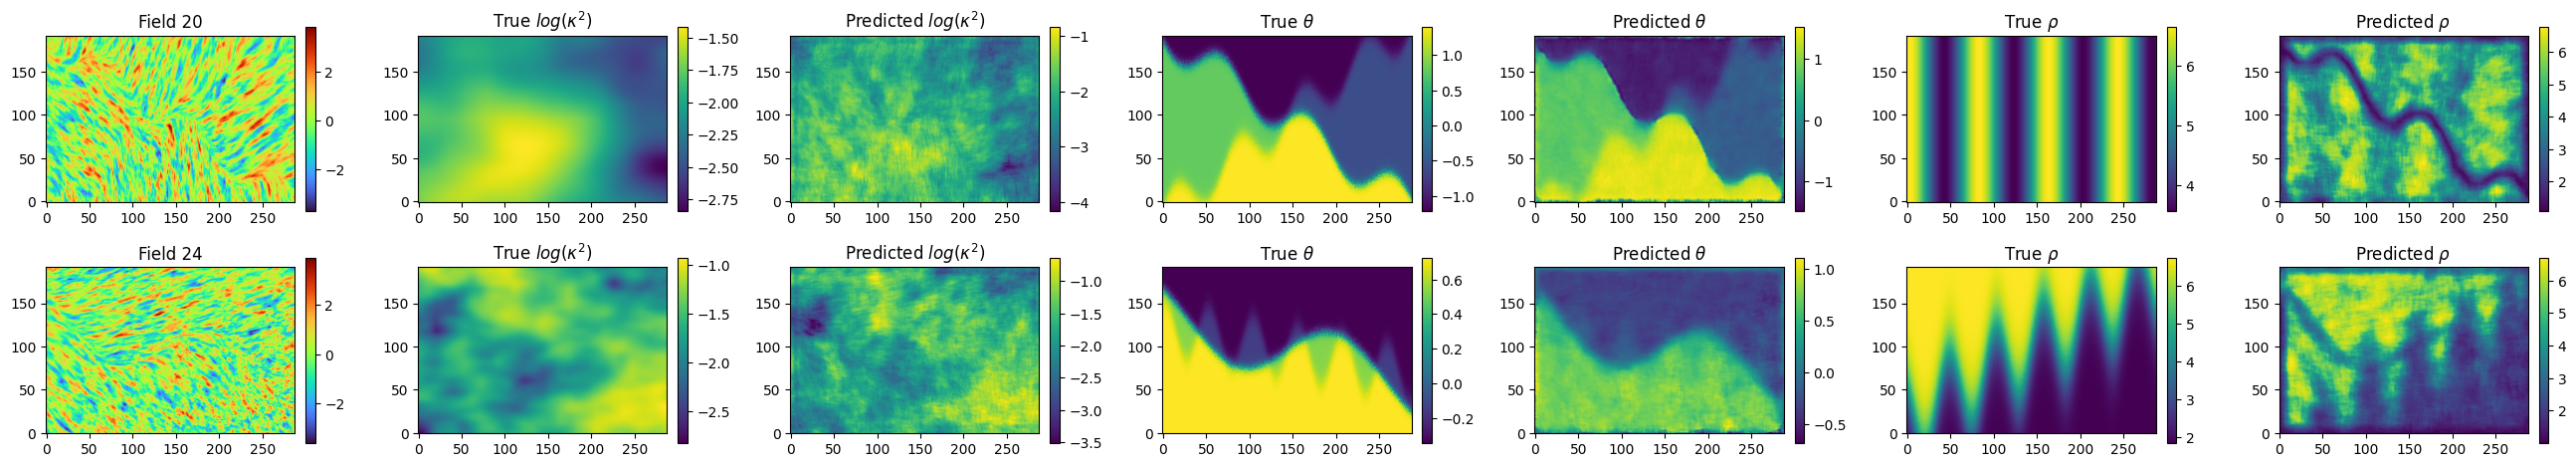

In [16]:
plot_img2img_samples(
	model=cnn_model,
	config=data_config,
	device=device,
	test_df=test_df,
	indices=inds,
	random_selection=False,
	num_rand_samples=5,
	awght_not_kappa2=False,
	show=True,
	cnn_mode=True,
	cnn_results=cnn_outputs,
)

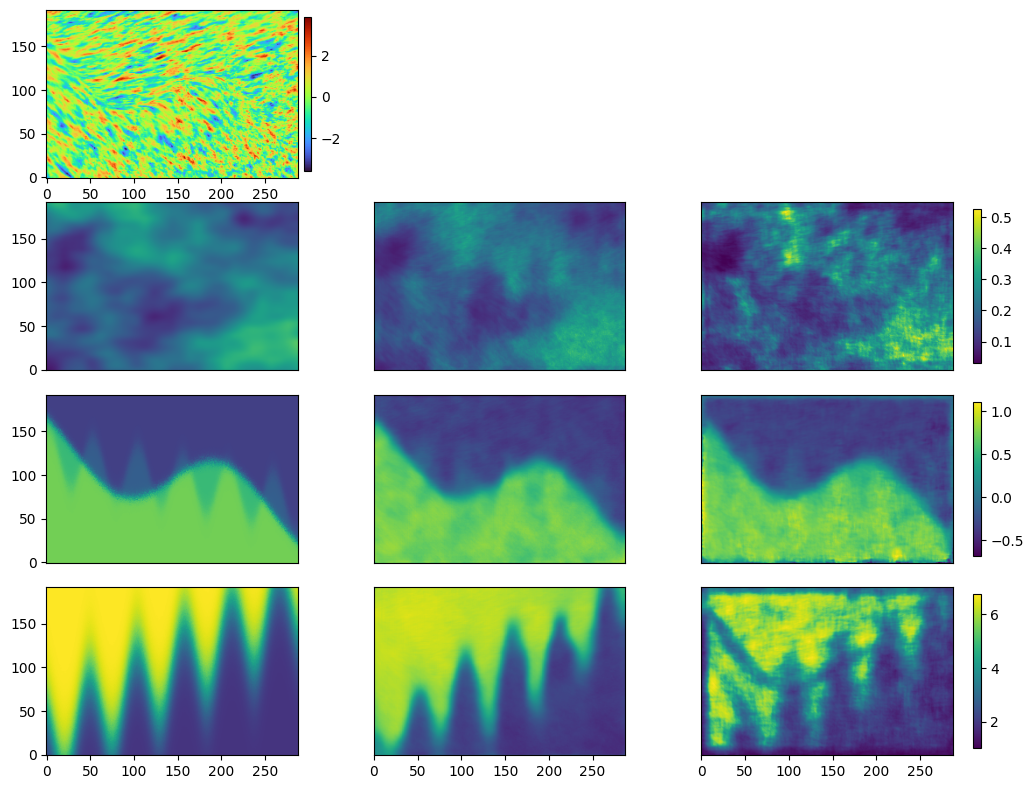

In [ ]:
def plot_img2img_samples2(
	stun_model: torch.nn.Module,
	cnn_model: torch.nn.Module,
	device: torch.device,
	test_df: Dataset,
	index: int,
	cnn_results: Optional[torch.Tensor] = None,
	save_path: Optional[str] = None,
	dpi: int = 300,
	show: bool = True,
) -> None:
	field, params = test_df[index]
	field_np = field[0].cpu().numpy()
	log_k2_true = params[0].cpu().numpy()
	true_k2 = np.exp(log_k2_true)
	true_th = params[1].cpu().numpy()
	true_rh = params[2].cpu().numpy()

	inp = field.unsqueeze(0).to(device)

	# pass through i2i model
	stun_pred = stun_model(inp)[0].cpu().detach().numpy()
	log_k2_stun, th_stun, rh_stun = stun_pred
	k2_stun = np.exp(log_k2_stun)

	# pass through cnn model
	if cnn_results is not None:
		cnn_pred = cnn_results[index].cpu().detach().numpy()
	else:
		cnn_pred = cnn_model(inp)[0].cpu().detach().numpy()
	log_k2_cnn, th_cnn, rh_cnn = cnn_pred
	k2_cnn = np.exp(log_k2_cnn)

	fig = plt.figure(figsize=(13, 10))
	gs = fig.add_gridspec(
		4, 3, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1], wspace=0.3, hspace=0
	)

	# row o constains spatial field
	ax_field = fig.add_subplot(gs[0, 0])
	im_field = ax_field.imshow(field_np, cmap="turbo")
	ax_field.invert_yaxis()
	fig.colorbar(
		im_field,
		ax=ax_field,
		orientation="vertical",
		fraction=0.08,
		pad=0.02,
		shrink=0.8,
	)

	# helper to plot each parameter row
	def plot_param_row(row, true_data, stun_data, cnn_data):
		vmin = min(true_data.min(), stun_data.min(), cnn_data.min())
		vmax = max(true_data.max(), stun_data.max(), cnn_data.max())
		# true params in col0
		ax_true = fig.add_subplot(gs[row, 0])
		im_true = ax_true.imshow(true_data, cmap="viridis", vmin=vmin, vmax=vmax)
		ax_true.invert_yaxis()
		# STUN in col1
		ax_stun = fig.add_subplot(gs[row, 1])
		im_stun = ax_stun.imshow(stun_data, cmap="viridis", vmin=vmin, vmax=vmax)
		ax_stun.invert_yaxis()
		ax_stun.set_yticks([])
		# CNN in col2
		ax_cnn = fig.add_subplot(gs[row, 2])
		im_cnn = ax_cnn.imshow(cnn_data, cmap="viridis", vmin=vmin, vmax=vmax)
		ax_cnn.invert_yaxis()
		ax_cnn.set_yticks([])
		# remove x-ticks for non-bottom rows
		if row != 3:
			ax_true.set_xticks([])
			ax_stun.set_xticks([])
			ax_cnn.set_xticks([])
		# shared vertical colorbar at right
		fig.colorbar(
			im_cnn,
			ax=[ax_true, ax_stun, ax_cnn],
			orientation="vertical",
			fraction=0.08,
			pad=0.02,
			shrink=0.8,
		)

	# plot param rows
	plot_param_row(1, true_k2, k2_stun, k2_cnn)
	plot_param_row(2, true_th, th_stun, th_cnn)
	plot_param_row(3, true_rh, rh_stun, rh_cnn)

	# high res saving
	if save_path:
		fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

	if show:
		plt.show()
	else:
		plt.close(fig)


plot_img2img_samples2(
	stun_model=stun_model,
	cnn_model=cnn_model,
	device=device,
	test_df=test_df,
	index=23,
	show=True,
	cnn_results=cnn_outputs,
	save_path="../results/figures/plot_sims.png",
	dpi=600,
)